<a href="https://colab.research.google.com/github/shubhamkoul007/Acquire-Valued-Shopper-Challenge-Team1-TDL/blob/main/Team1_Project1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns




In [177]:
data = pd.read_excel("Online Retail.xlsx" )

In [178]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [179]:
data.shape

(541909, 8)

In [180]:
data.isnull().sum(axis=0) 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [181]:
#There are 1,35,000 entries where customer id is null.
#Copying all the non null entries to the new data object 
#that doesn't have null entries for customerid

data = data[ pd.notnull(data['CustomerID'])]


In [182]:
len(data[data['Quantity'] < 0 ]) 

8905

In [183]:
#Removing all the entries(rows) that have negative quantity

data = data[data['Quantity'] > 0 ] 

#Adding a new column depicting total sales

data['Total_Sales'] = data['Quantity'] * data['UnitPrice']

In [184]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [185]:
df = data.copy()

import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['day'] = df['InvoiceDate'].dt.day
df['month'] = df['InvoiceDate'].dt.month
df['hour']=df['InvoiceDate'].dt.hour
df['weekday'] = df['InvoiceDate'].dt.dayofweek



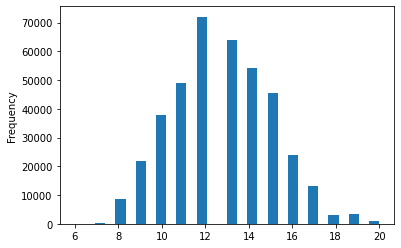

In [186]:
df['hour'].plot(kind='hist', bins=30)

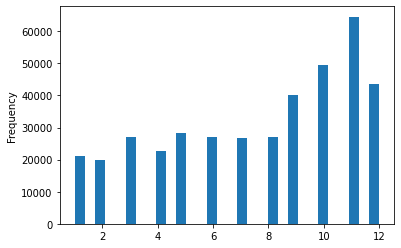

In [187]:
df['month'].plot(kind='hist', bins=30)

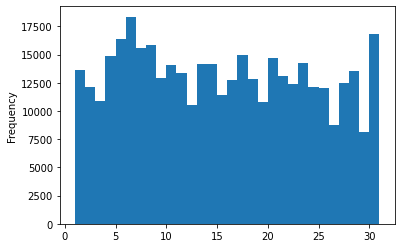

In [190]:
df['day'].plot(kind='hist', bins=30)

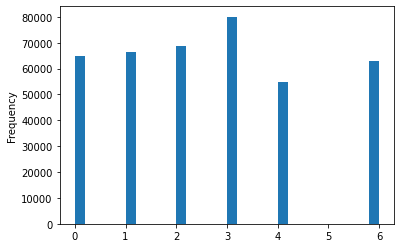

In [189]:
df['weekday'].plot(kind='hist', bins=30)

In [191]:
#Removing the time from Invoice Date

data['InvoiceDate'] = pd.to_datetime( data['InvoiceDate'] , format = "%y %m %d %H:%M" ).dt.date

In [192]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [193]:

#Getting required columns only
required_cols = ['CustomerID' , 'InvoiceDate' , 'Total_Sales']

data = data[required_cols]

data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [194]:
data['CustomerID'].nunique()

4339

In [195]:
#Getting the last order date

last_order_date = data['InvoiceDate'].max()

last_order_date


datetime.date(2011, 12, 9)

**Pareto's 80-20 rule**

It states that 80% results come from 20% causes. In this context,we can say 20% customers contribute to 80% total revenue.We will try to verify it here. If it is verified ,we can know which customers to focus on.

In [196]:

#get 80% of our total revenue
pareto_cutoff=data['Total_Sales'].sum()*0.8
print("80% of total revenue is")
print(round(pareto_cutoff,2))



80% of total revenue is
7129126.32


In [197]:
df_customer_rank=data.groupby(['CustomerID'] , as_index = False )['Total_Sales'].sum()

df_customer_rank.head()




,CustomerID,Total_Sales
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [198]:
pareto_cutoff1=df_customer_rank['Total_Sales'].sum()*0.8
print("80% of total revenue is")
print(round(pareto_cutoff,2))

80% of total revenue is
7129126.32


In [199]:

#make customer ID as index
df_customer_rank=df_customer_rank.set_index('CustomerID')

df_customer_rank.head()



,Total_Sales
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [200]:
df_customer_rank["Rank"]=df_customer_rank["Total_Sales"].rank(ascending=False)
df_customer_rank.head()

,Total_Sales,Rank
CustomerID,,
12346.0,77183.60,10.0
12347.0,4310.00,336.0
12348.0,1797.24,1006.0
12349.0,1757.55,1034.0
12350.0,334.40,3110.0


In [201]:
#sort by rank to get top customers
df_customer_rank.sort_values('Rank',ascending=1 ,inplace = True)

df_customer_rank.head(20)

,Total_Sales,Rank
CustomerID,,
14646.0,280206.02,1.0
18102.0,259657.30,2.0
17450.0,194550.79,3.0
16446.0,168472.50,4.0
14911.0,143825.06,5.0
12415.0,124914.53,6.0
14156.0,117379.63,7.0
17511.0,91062.38,8.0
16029.0,81024.84,9.0


In [202]:
data['CustomerID'].nunique()


4339

In [203]:
data['CustomerID'].nunique() *0.2 

867.8000000000001

In [204]:

top_20percent_Customer = data['CustomerID'].nunique() *0.2 

#total revenue generation from these top 20 % customers
observed_pareto_cutoff = df_customer_rank[df_customer_rank["Rank"]<= top_20percent_Customer]['Total_Sales'].sum()

print(observed_pareto_cutoff)

if observed_pareto_cutoff > pareto_cutoff:
   print("Our Model verifies Pareto's 80 20 rule")
else:
   print("Our Model fails to Verify Pareto's 80 20 rule")


6647378.010999998
Our Model fails to Verify Pareto's 80 20 rule


In [205]:
!pip install lifetimes

In [206]:
from lifetimes.plotting import *
from lifetimes.utils import *

#Built-in utility functions from lifetimes package to 
#transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_data = summary_data_from_transaction_data(data, 'CustomerID' , 'InvoiceDate' , monetary_value_col = 'Total_Sales' , observation_period_end = '2011-12-9')

lf_data.reset_index().head()


,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


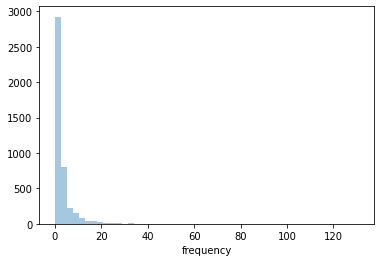

In [207]:
sns.distplot( lf_data['frequency'] ,kde= False,  bins=50)



(0.0, 30.0)

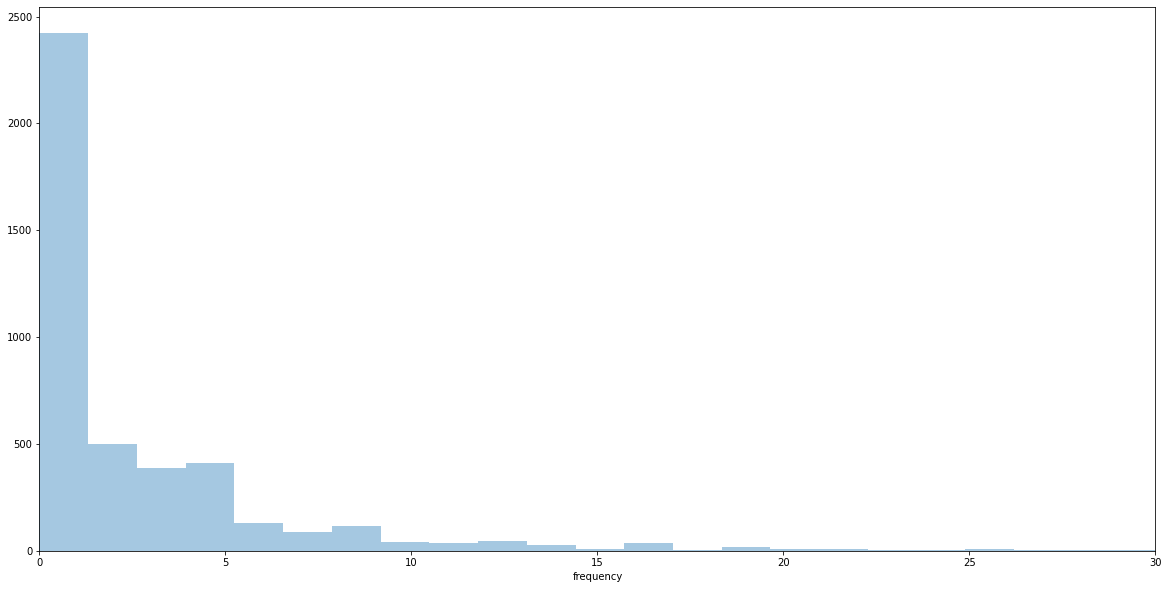

In [208]:

plt.figure(figsize = (20,10))
sns.distplot( lf_data['frequency'] ,kde= False,  bins=100)

sns.distplot
plt.xlim(0 , 30)


In [209]:
from lifetimes import BetaGeoFitter

bgf= BetaGeoFitter(penalizer_coef = 0.0 )

bgf.fit( lf_data['frequency'] , lf_data['recency']  , lf_data['T'] )

bgf



<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [210]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


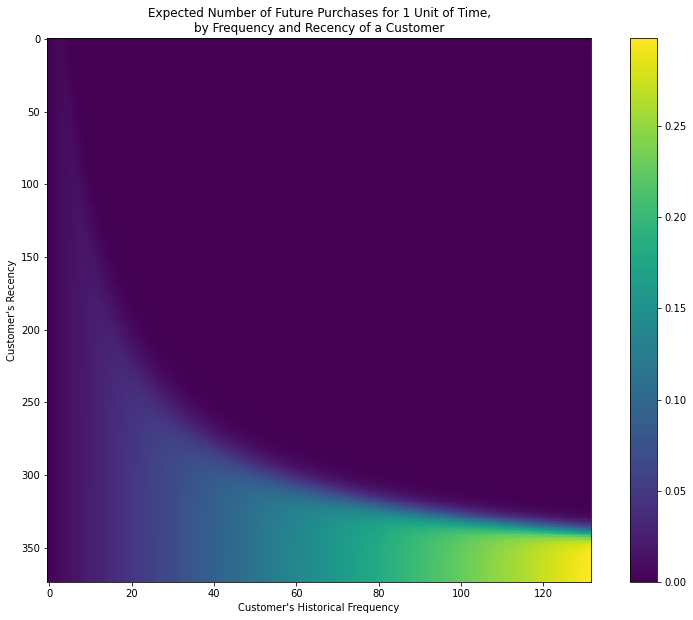

In [211]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize = (14 , 10))
plot_frequency_recency_matrix(bgf)


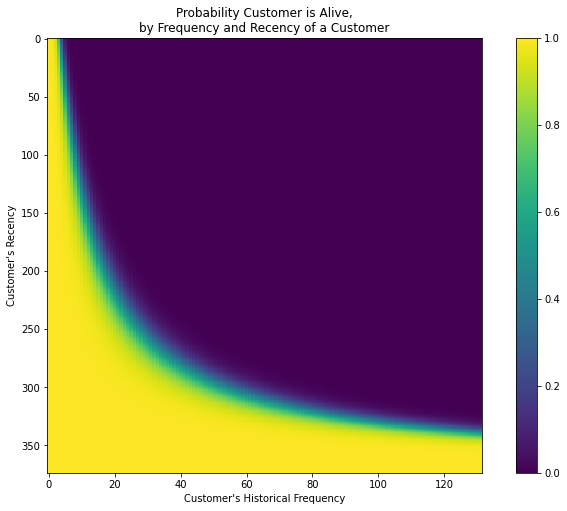

In [212]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [213]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, based on historical data

t = 10
lf_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_data['frequency'], lf_data['recency'], lf_data['T']),2)
lf_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index() 


,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


<Figure size 1440x720 with 0 Axes>

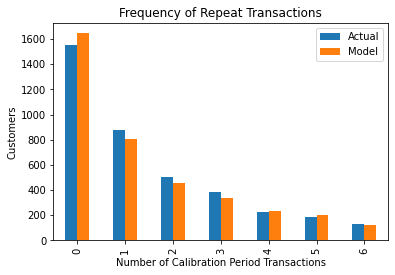

In [214]:
from lifetimes.plotting import plot_period_transactions

fig = plt.figure(figsize = (20 , 10))

plot_period_transactions(bgf)

In [215]:

#Customer's future transaction prediction for next 10 days

t = 10
individual = lf_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 3 in 10 days.



2.983023863904241

In [216]:


#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_data[['monetary_value', 'frequency']].corr()



,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [217]:

#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_data[lf_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))



   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are:  2790


In [218]:

#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)



<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [219]:

#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_data['frequency'],
        lf_data['monetary_value']
    ).head(10))



CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [220]:


lf_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_data['frequency'],
        lf_data['monetary_value']), 2)
lf_data.reset_index().head()



,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [221]:
#Calculate Customer Lifetime Value
lf_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, lf_data['frequency'],lf_data['recency'],
    lf_data['T'], lf_data['monetary_value'],
    time=12, discount_rate=0.01 ), 2)

lf_data.drop( lf_data.iloc[:, 0:6], inplace=True, axis=1 )

lf_data.sort_values(by='CLV', ascending=False).head(10).reset_index()


,CustomerID,CLV
0,14646.0,222128.93
1,18102.0,178895.33
2,16446.0,175531.47
3,17450.0,147476.62
4,14096.0,127589.20
5,14911.0,109442.13
6,12415.0,96290.23
7,14156.0,89410.33
8,17511.0,67660.41
9,16029.0,58729.62
